<h1><center>Lab n 2 </h1>
<h1><center>Image captioning using transformer decoder<center></h1>

## Introduction

AI Image captioning is a process that involves generating descriptive textual content for images using machine learning models. Image captioning typically leverages convolutional neural networks (CNNs) for visual feature extraction from the images and recurrent neural networks (RNNs), like Long Short-Term Memory (LSTM) networks, for generating the corresponding text. Recent advances also utilize transformer-based models which combine image and text modalities more effectively.
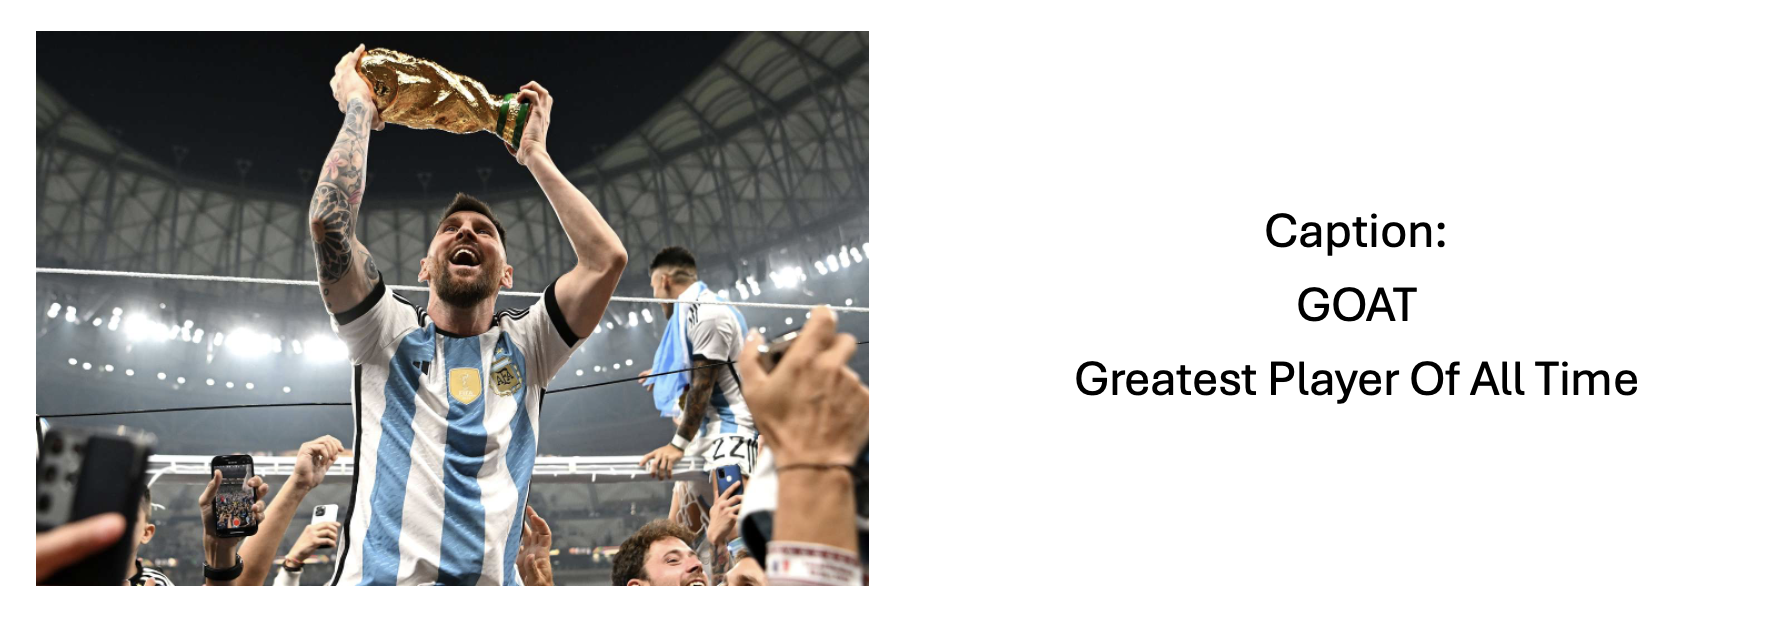
Image captioning has applications in accessibility, content creation, and search engine optimization, making it a versatile tool in modern AI applications. For a lab in JupyterLab, you can explore these models, utilize pre-trained versions, and test them on various datasets to understand their performance and limitations.

## Instructions:

Throughout the notebook you will find comments like `# Put your code here`. In those cases, you are expected to complete the code appropriately.

* Training time should take around 10 minutes with a GPU.

In [ ]:
from IPython.display import clear_output, display

# Initial Step
### Installing the required libraries:

In [ ]:
%pip install torch==2.2.0+cu118 torchvision==0.17.0+cu118 pillow spacy numpy -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
%pip install torchtext==0.17.0
%pip install pycocotools

# Step 1: Loading libraries + Data

In [ ]:
import os
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoCaptions
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from PIL import Image
import spacy

In [ ]:
dataset_variant = 'val2017'

## Downloading the data

In [ ]:
# Define paths for dataset and annotations
data_dir = './data'
images_dir = os.path.join(data_dir, dataset_variant)
annotations_dir = os.path.join(data_dir, 'annotations')

# Create directories if they don't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
if not os.path.exists(annotations_dir):
    os.makedirs(annotations_dir)

# Download dataset
!wget http://images.cocodataset.org/zips/{dataset_variant}.zip -P {data_dir}

# Unzip dataset
!unzip {data_dir}/{dataset_variant}.zip -d {data_dir}

clear_output()


In [ ]:
# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {annotations_dir}

# # Unzip annotations
!unzip {annotations_dir}/annotations_trainval2017.zip -d {annotations_dir}

clear_output()

## Loading the Dataset

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )

# Load MS-COCO dataset
train_dataset = CocoCaptions(root=f'./data/{dataset_variant}', annFile=f'./data/annotations/annotations/captions_{dataset_variant}.json', transform=transform)

# Step 2: Building the tokenizer and vocabulary

Word_tokenize() is simple word tokenization function using the spaCy library in Python. Tokenization is the process of breaking down text into individual words or tokens, which is a common preprocessing step in natural language processing (NLP) tasks.

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")
def word_tokenize(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

We use word_to_index to map words to their corresponding indices.

It includes four special tokens: \<PAD>, \<SOS>, \<EOS>, and \<UNK>.

These tokens are commonly used in natural language processing tasks. <PAD> is used for padding sequences to make them of equal length, \<SOS> represents the start of a sentence, \<EOS> represents the end of a sentence, and \<UNK> represents unknown words.

#### Task: Assign an index to each token

In [ ]:


# Define the vocabulary and tokenizer
word_to_index = {'<PAD>':0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
# index_to_word is the inverse of word_to_index, which maps indices to words.
index_to_word = {it: k for k, it in word_to_index.items()}
word_freq = {}
caption_lengths = []

# Tokenize captions and build vocabulary
# The vocabulary is a dictionary that maps words to indices.
# Each token in the caption have a corresponding index in the vocabulary.
for _, captions in tqdm(train_dataset):
    for caption in captions:
        caption = f'{caption}'
        caption_lengths.append(len(caption))
        tokens = word_tokenize(caption.lower())
        for token in tokens:

            #question : What is the index of the new word?
            if token not in word_to_index:
                idx =  # Put your code here
                word_to_index[token] = # Put your code here
                index_to_word[idx] = # Put your code here
                word_freq[token] = 1
            else:
                word_freq[token] += 1

In [ ]:
word_tokenize('<SOS> hi, my friend <EOS>')  # We will manually add tokens for <EOS> and <SOS> etc after tokenization to avoid them breaking up.

# Step 3: Defining the Model



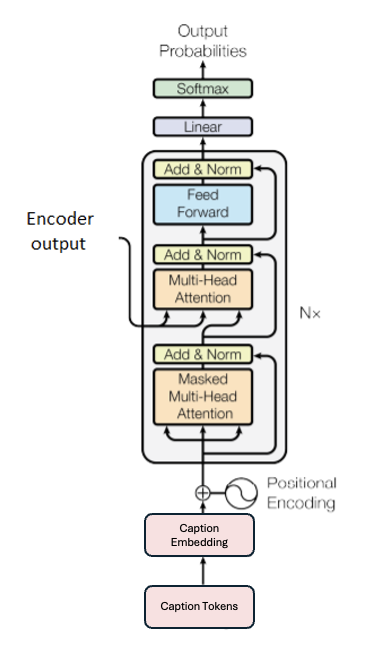

The first component of the model is Resnet50 pretrained model which will be used for feature extraction
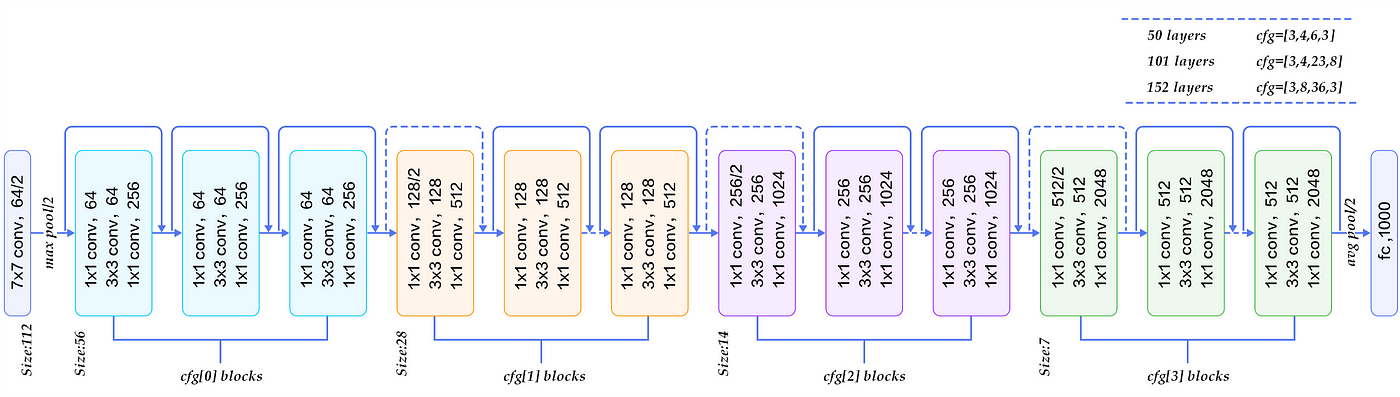

In [ ]:
#The EncoderCNN will take the image and output a feature vector of size embed_size.
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        self.resnet = models.resnet50(pretrained=True).requires_grad_(False)  # resnet embedding backbone
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):

        features = self.resnet(images)
        return self.dropout(self.relu(features))

The Positional Encoding class is used to generate and apply positional encodings to input tensors, which is a crucial component in transformer models for capturing the order of sequences.
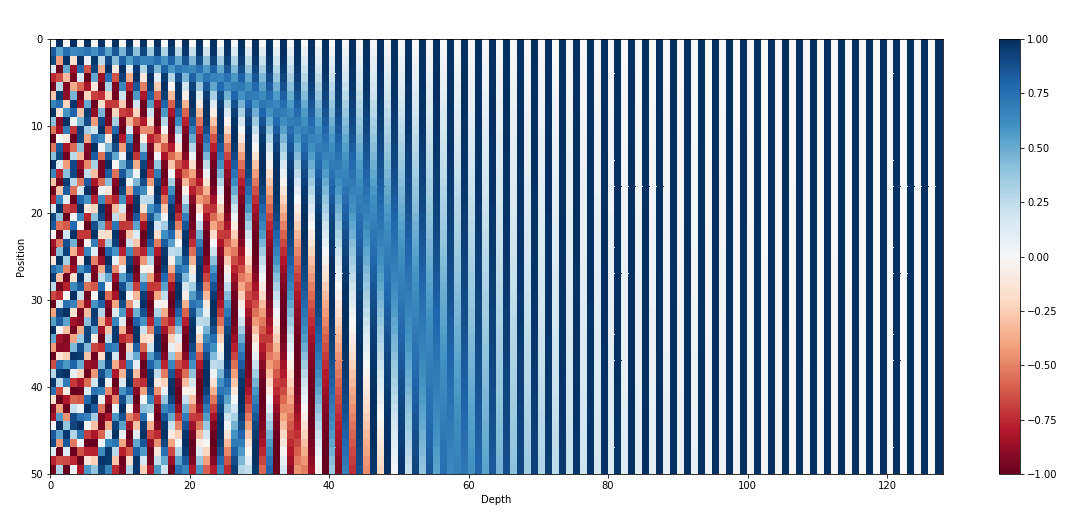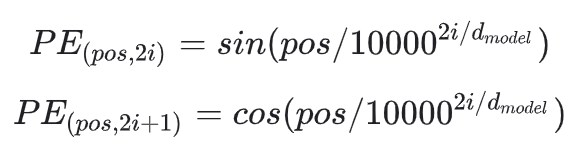
#### Task: complete the sin positional encoding

In [ ]:
#The PositionalEncoding module adds positional encodings to the input embeddings.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=200):
        super(PositionalEncoding, self).__init__()

        self.register_buffer('pe', self._get_positional_encoding(max_seq_length, d_model))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

    def _get_positional_encoding(self, max_seq_length, d_model):
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # sin for even indices
        pe[:, 0::2] = # Put your code here
        # cos for odd indices
        pe[:, 1::2] = # Put your code here
        pe = pe.unsqueeze(0)  # Add batch dimension
        return pe


The Decoder class is designed to serve as a transformer-based decoder, typically used in tasks such as image captioning where the model generates sequences (e.g., captions) based on input features (e.g., image embeddings).

#### Task: complete the decoder layer

In [ ]:
class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, heads, num_layers, vocab_size, max_seq_length, batch_first=True):
        super(DecoderTransformer, self).__init__()
        self.embed_size = embed_size
        self.batch_first = batch_first
        # The embedding layer will convert word indices to embeddings
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The positional encoding layer will add positional encodings to the input embeddings
        self.position_encoding = PositionalEncoding(embed_size, max_seq_length)
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(embed_size, heads, batch_first=True)
        # The transformer decoder plus the linear will take the embeddings and output the predicted word indices
        self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, features, captions, captions_mask=None):
        if not self.batch_first:
            captions = captions.permute(1, 0, 2)
        # Embed the captions
        embeddings = # Put your code here
        # Add positional encoding to the embeddings
        embeddings = # Put your code here
        features = features.unsqueeze(1)  # add a dimension for the transformer
        output = self.transformer_decoder(embeddings, features, tgt_mask=captions_mask, tgt_is_causal=(True if captions_mask is not None else False))
        output = self.fc(output)
        if not self.batch_first:
            output = output.permute(1, 0, 2)
        return output

Now the complete model is designed to generate captions for images using a combination of a Convolutional Neural Network (CNN) encoder and a Transformer-based decoder.


In [ ]:
class ImageCaptioner(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptioner, self).__init__()
        # The encoderCNN will take the image and output a feature vector of size embed_size
        # The decoder will take the feature vector and output a sequence of words
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoder = DecoderTransformer(embed_size, 8, num_layers, vocab_size, 100)

    def forward(self, images, captions, captions_mask):
        features = self.encoderCNN(images)
        outputs = self.decoder(features, captions, captions_mask)
        return outputs

    def caption_image(self, image, max_length=50):
        # Inference method to generate captions
        with torch.no_grad():
            features = self.encoderCNN(image)
            # We feed the start token to the decoder
            start_token = torch.tensor([word_to_index['<SOS>']], dtype=torch.long).unsqueeze(0)
            generated_caption = [start_token.item()]
            for _ in range(max_length):  # maximum sequence length
                inputs = torch.tensor(generated_caption, dtype=torch.long).unsqueeze(0).to(features.device)
                outputs = self.decoder(features, inputs)
                predicted = outputs.argmax(2)[:,-1].item()
                generated_caption.append(predicted)
                # If we predict the end token, we stop the loop
                if predicted == word_to_index['<EOS>']:
                    break
        generated_caption = generated_caption[1:-1]  # Remove start and end tokens
        generated_caption = [index_to_word[i] for i in generated_caption]
        return generated_caption

# Step 4: Defining the dataset

The dataloader returns a tuple of image, caption, and caption mask
#### Task: Add Special tokens to each caption (\<PAD>, \<SOS>, \<EOS>)

In [ ]:
def convert_sentence_to_idxs(sentence):
    words = word_tokenize(sentence)
    idxs = [word_to_index[word] for word in words]
    return idxs

def convert_idxs_to_sentence(idxs):
    words = [index_to_word[idx] for idx in idxs]
    return ' '.join(words)

def causal_mask(size):
    mask = torch.triu(torch.ones((size, size)), diagonal=1).type(torch.int)
    return mask == 0

class CoCoCaptionsDataset(Dataset):
    def __init__(self, default_coco_dataset, max_seq_len):
        self.coco = default_coco_dataset
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.coco)

    def __getitem__(self, idx):
        img, captions = self.coco[idx]
        # caption = random.choice(captions, k=1)[0]
        caption = captions[0]
        caption_idxs = convert_sentence_to_idxs(caption.lower().strip())
        if len(caption_idxs) > self.max_seq_len - 2:  # 2 for SOS and EOS
            caption_idxs = caption_idxs[:self.max_seq_len-2]

        padding_len = self.max_seq_len - len(caption_idxs) - 2  # need to pad to make it to seq_len. All captions Need to be of same length so they can be stacked

        # Add start and end tokens along with padding
        # Padding is done to make all captions of the same length
        # Padding is done with the <PAD> token multiplied by the padding length

        caption = # Put your code here

        caption = torch.Tensor(caption)
        # Caption mask is used to mask to help the model ignore the padding tokens
        caption_pad_mask = (caption != word_to_index['<PAD>'])
        caption_mask = caption_pad_mask.unsqueeze(0)&causal_mask(caption.size(0))

        return img, caption, caption_mask


batch_size = 128
fixed_train_dataset = CoCoCaptionsDataset(train_dataset, max_seq_len=50)
train_loader = DataLoader(fixed_train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Step 5: Training and Testing the model

## Pre-training Testing

### Model training parameters

In [ ]:
embed_size = 512
hidden_size = 256
vocab_size = len(word_to_index)
num_decoder_layers = 4
learning_rate = 1e-4
num_epochs = 20

### Model optimizer and loss function

#### Task : Set the optimizer loss criterion

In [ ]:
# initialize model, loss etc
model = ImageCaptioner(embed_size, hidden_size, vocab_size, num_decoder_layers).to(device)
# The criterion is high when the predicted probability distribution is far from the target distribution
# !!!! Set the ignore_index=word_to_index['<PAD>'] to ignore the padding tokens

criterion = # Put your code here
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Only finetune the CNN
for name, param in model.encoderCNN.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
#Picking a few images to test the model
test_img_paths = ['data/val2017/000000000139.jpg', 'data/val2017/000000000632.jpg', 'data/val2017/000000000724.jpg']
imgs_pil = [Image.open(path).convert('RGB') for path in test_img_paths]
imgs_test = [transform(im_pil).to(device) for im_pil in imgs_pil]

In [ ]:
imgs = torch.stack(imgs_test, 0)
model.eval()
captions = []
# Generate captions for the test images before training
for img, img_pil in zip(imgs_test, imgs_pil):
    with torch.no_grad():
        caption = model.caption_image(img.unsqueeze(0))
        caption = ' '.join(caption)

        display(img_pil)
        print(caption)
        print('-'*20)

## Training the model

In [ ]:
#Training loop
for epoch in range(num_epochs):

    model.train()

    for idx, (imgs, captions, captions_mask) in tqdm(
        enumerate(train_loader), total=len(train_loader), leave=False
    ):
        imgs = imgs.to(device)
        captions = captions.to(device).type(torch.long)
        captions_mask = captions_mask.to(device)

        captions_mask = captions_mask[:, 1:, 1:]

        outputs = model(imgs, captions[:, :-1], captions_mask[:, :-1])

        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'\nEpoch: {epoch+1}/{num_epochs}', "Training loss: ", loss.item())

## Testing the model

In [ ]:
#Picking an image from the validation set and generating a caption
img = Image.open('data/val2017/000000001490.jpg').convert('RGB')
img


In [ ]:
img_t = transform(img).to(device).unsqueeze(0)
model.eval()
with torch.no_grad():
    caption = model.caption_image(img_t)

caption

In [ ]:
# Testing on some images after training
for img, img_pil in zip(imgs_test, imgs_pil):
    with torch.no_grad():
        caption = model.caption_image(img.unsqueeze(0))
        caption = ' '.join(caption)

        display(img_pil)
        print(caption)
        print('-'*20)